In [5]:
import pandas as pd

old_tweets = pd.read_csv("data/old_tweets.csv").drop(columns=['Screen_name', 'Source', 
                                                           'Link','Sentiment','sent_score','New_Sentiment_State'])
old_tweets.head()

,Unnamed: 0,Date,Tweet,New_Sentiment_Score
0,0,Fri Mar 23 00:40:32 +0000 2018,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",0.000000
1,1,Fri Mar 23 00:40:34 +0000 2018,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,0.000000
2,2,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,0.136364
3,3,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,0.400000
4,4,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,0.468182


In [6]:
import re 

# Provide case insensitive data
tweets = old_tweets["Tweet"].str.lower().astype(str)

# Take out links with or without www
tweets = tweets.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
tweets = tweets.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))

# Take out possible HTML character references 
tweets = tweets.apply(lambda x: re.sub(r'&[a-z]+;', '', x))

# Take out nonletter characters except for spaces and sentence delimitators
tweets = tweets.apply(lambda x: re.sub(r"[^a-z\s.!?]", '', x))

# Sometimes twitter data has links preprocessed into a reference such as {link}
tweets = tweets.apply(lambda x: re.sub(r'{link}', '', x))

# Noticed the dataset contains at user and url references so we can remove them
tweets = tweets.str.replace('url', '')
tweets = tweets.str.replace('atuser', '')

old_tweets["Tweet"] = tweets

old_tweets.head()

,Unnamed: 0,Date,Tweet,New_Sentiment_Score
0,0,Fri Mar 23 00:40:32 +0000 2018,rt alxtoken paul krugman nobel luddite. i had ...,0.000000
1,1,Fri Mar 23 00:40:34 +0000 2018,lopp kevinpham psychosage naval but proffaustu...,0.000000
2,2,Fri Mar 23 00:40:35 +0000 2018,rt tippereconomy another use case for blockcha...,0.136364
3,3,Fri Mar 23 00:40:36 +0000 2018,free coins,0.400000
4,4,Fri Mar 23 00:40:36 +0000 2018,rt payvxofficial we are happy to announce that...,0.468182


In [156]:
import nltk
from nltk.tokenize import RegexpTokenizer

tweets = list(zip(old_tweets["Tweet"], old_tweets['New_Sentiment_Score']))

regextk = RegexpTokenizer('\s+', gaps=True)

tokens = [(regextk.tokenize(tweet), sentiment) for (tweet, sentiment) in tweets if type(tweet) == str]

tagged = [(nltk.pos_tag(tweet), sentiment) for tweet, sentiment in tokens]

tagged[3]

([('free', 'JJ'), ('coins', 'NNS')], 0.4)

In [157]:
import string
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

def wn_pos(tag):
    "converts treebank tags into wordbank tags for lemmatization"
    if tag.startswith('J'):
        return wn.ADJ
    if tag.startswith('V'):
        return wn.VERB
    if tag.startswith('N'):
        return wn.NOUN
    if tag.startswith('R'):
        return wn.ADV
    return None

lem_tweets = []
lem = WordNetLemmatizer()

for tweet in tagged:
    lemmas = []
    
    for word, tag in tweet[0]:
        wn_tag = wn_pos(tag)
        
        if word[-1] in string.punctuation:
                word = word[:-1]

        if wn_pos(tag) is not None:
            lemmas.append(lem.lemmatize(word, wn_tag))
        else:
            lemmas.append(lem.lemmatize(word))
                
    lem_tweets.append((lemmas, tweet[1]))

lem_tweets[3]

(['free', 'coin'], 0.4)

In [7]:
pd.DataFrame(lem_tweets).to_csv("proccessed_old.csv")

NameError: name 'lem_tweets' is not defined

In [8]:
import pandas as pd
import numpy as np

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

old_tweets = pd.read_csv("data/proccessed_old.csv").drop(columns="Unnamed: 0").rename(columns={"0":"Tweet", "1":"Sentiment"})

# joining data back to strings
new = []
for tweet in old_tweets["Tweet"]:
    new.append((tweet[1:-1].replace(",", "").replace("'", "")))
    
data = pd.DataFrame(zip(new, old_tweets['Sentiment']), columns=["Tweet", "Sentiment"])
data = clean_dataset(data)

Xo = data['Tweet'].astype(str)
yo = data['Sentiment']

In [9]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split

count = CountVectorizer()
tfidf_transformer = TfidfTransformer()

# split data for train and test
X_traino, X_testo, y_traino, y_testo = train_test_split(Xo, yo, train_size=0.8)

train_counts = count.fit_transform(X_traino)
train_tfidf = tfidf_transformer.fit_transform(train_counts)

In [10]:
from sklearn.linear_model import SGDRegressor, Ridge

ridgeo = Ridge().fit(train_tfidf, y_traino)

In [11]:
from sklearn.metrics import mean_squared_error

X_test_Vo = count.transform(X_testo)
X_to = tfidf_transformer.transform(X_test_Vo)
y_predo = ridgeo.predict(X_to)

mean_squared_error(y_testo, y_predo)

0.007891930773759062

In [12]:
import pandas as pd
import numpy as np

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

lem_tweets = pd.read_csv("data/lem_tweets.csv").drop(columns="Unnamed: 0").rename(columns={"0":"Tweet", "1":"Sentiment"})

# joining data back to strings
new = []
for tweet in lem_tweets["Tweet"]:
    new.append((tweet[1:-1].replace(",", "").replace("'", "")))
    
data = pd.DataFrame(zip(new, lem_tweets['Sentiment']), columns=["Tweet", "Sentiment"])
data = clean_dataset(data)

X = data['Tweet']
y = data['Sentiment']

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split

count = CountVectorizer()
tfidf_transformer = TfidfTransformer()

# split data for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

train_counts = count.fit_transform(X_train)
train_tfidf = tfidf_transformer.fit_transform(train_counts)

In [14]:
from sklearn.linear_model import SGDRegressor, Ridge

ridge = Ridge().fit(train_tfidf, y_train)

In [15]:
from sklearn.metrics import mean_squared_error

X_test_V = count.transform(X_testo)
X_t = tfidf_transformer.transform(X_test_V)
y_pred = ridge.predict(X_t)

mean_squared_error(y_testo, y_pred)

0.10352379865498709

In [16]:
X_test_V = count.transform(X_test)
X_t = tfidf_transformer.transform(X_test_V)
y_pred = ridgeo.predict(X_t)

mean_squared_error(y_test, y_pred)

ValueError: dimension mismatch

When comparing the prediction using a model trained on the old dataset (50k) and one trained on our actual dataset (1.4m), the MSE is 0.0065 as compared to 0.1092

In [139]:
from nltk.corpus import stopwords

pos=lem_tweets[lem_tweets['Sentiment'].between(0.1, 1)]

neg=lem_tweets[lem_tweets['Sentiment'].between(-1, -0.1)]

In [140]:
pos

,Tweet,Sentiment
1,"['please', 'donate', 'bitcoin', 'donate', 'cha...",0.6597
3,"['bitcoin', 'btc', 'current', 'price', 'gbp', ...",0.3612
7,"['keep', 'goin', 'and', 'have', 'luck', 'btc',...",0.5093
15,"['pi', 'quote', 'mine', 'pi', 'secs', 'a', 'da...",0.4003
18,"['follow', 'me', 'on', 'let', 'hunt', 'for', '...",0.5411
...,...,...
1519547,"['the', 'buy', 'signal', 'for', 'doge', 'that'...",0.2732
1519549,"['i', 'will', 'buy', 'doge', 'around', '', 'to...",0.4033
1519550,"['bitcoin', 'binary', 'trading', 'invest', 'wi...",0.2732
1519553,"['join', 'me', 'at', 'bybit', 'and', 'get', 'a...",0.9259


In [141]:
import pandas as pd
from matplotlib import pyplot as plt
import nltk

new = []
for tweet in pos["Tweet"]:
    new.append((tweet[1:-1].replace(",", "").replace("'", "")).split())
                              
words = [w for l in new for w in l]




In [142]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
wds=["bitcoin",'bnb','the','and','this','for','will','you','bsc','have','eth',
     'xrp','new','keep','bch','erc','xvg','per','bcc','lee','.kb','enu','feg',
     'fegexv','!!!','zec','erc','chz','rune','gze','pvx','nvk','enj','xlc','ebzz','rvn','feel','rule','fee','evx','knw','vlc','xrb','run']+stop

w=[i for i in words if len(i) >= 3]
   
freq = nltk.FreqDist(w) #number of occurances of each word
freqdf = pd.DataFrame({'Words': list(freq.keys()), 'Count': list(freq.values())})   
for wd in wds:
    freqdf=freqdf[freqdf['Words'].str.contains(wd)==False]

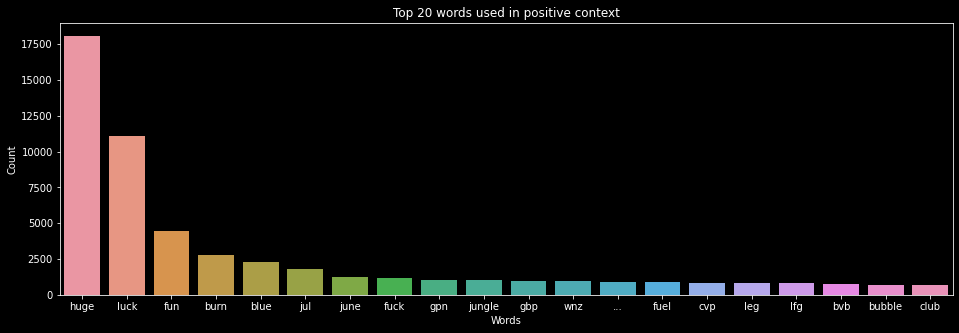

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

freqdff = freqdf.nlargest(columns='Count', n = 20)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=freqdff, x= 'Words', y = 'Count')
ax.set(ylabel = 'Count')
ax.set(xlabel = 'Words')
plt.title("Top 20 words used in positive context")
plt.show()

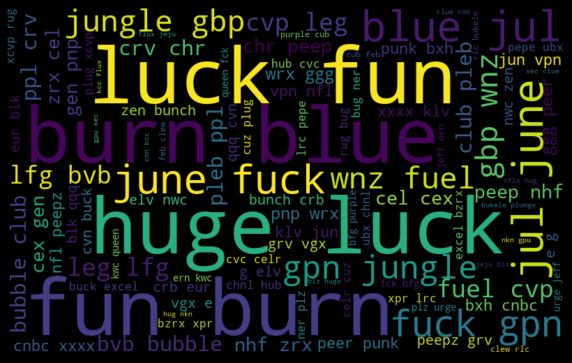

In [144]:
from wordcloud import WordCloud
freqdf = freqdf.nlargest(columns="Count", n = 100)
comment_words = ''
fr=list(freqdf['Words'])
        
for i in range(len(fr)):
    comment_words += " ".join(fr)+" "

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(comment_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [145]:
import pandas as pd
from matplotlib import pyplot as plt
from nltk.corpus import stopwords

new = []
for tweet in neg["Tweet"]:
    new.append((tweet[1:-1].replace(",", "").replace("'", "")).split())
                              
words = [w for l in new for w in l]

In [146]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
wds=["bitcoin",'bnb','the','and','this','for','will','you','bsc','have','eth',
     'xrp','new','keep','bch','erc','xvg','per','bcc','lee','.kb','enu','feg',
     'fegexv','!!!','zec','erc','chz','rune','gze','pvx','nvk','enj','xlc','ebzz','rvn','feel','rule','fee','evx','evx','knw','vlc','xrb','run']+stop

w=[i for i in words if len(i) >= 3]
   
freq = nltk.FreqDist(w) #number of occurances of each word
freqdfn = pd.DataFrame({'Words': list(freq.keys()), 'Count': list(freq.values())})   
for wd in wds:
    freqdfn=freqdfn[freqdfn['Words'].str.contains(wd)==False]
    

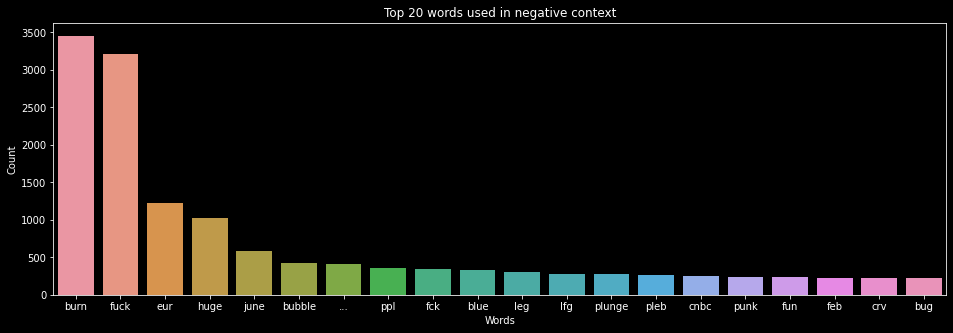

In [147]:
plt.style.use('dark_background')
freqdfnn = freqdfn.nlargest(columns="Count", n = 20)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=freqdfnn, x= "Words", y = "Count")
ax.set(ylabel = 'Count')
ax.set(xlabel = 'Words')
plt.title("Top 20 words used in negative context")
plt.show()

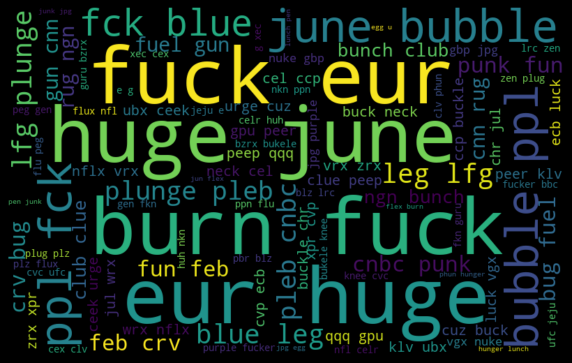

In [148]:
freqdfn = freqdfn.nlargest(columns="Count", n = 100)
comment_words = ''
fr=list(freqdfn['Words'])
        
for i in range(len(fr)):
    comment_words += " ".join(fr)+" "

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(comment_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()